# 1. 이해하기

## 1.1 전체 흐름

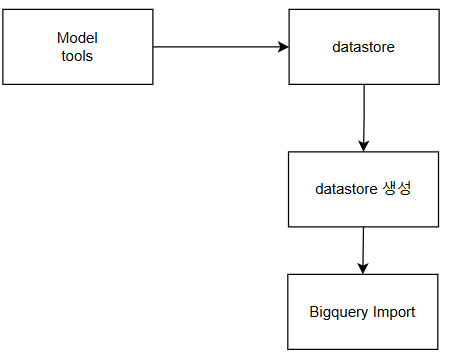

## 1.2 Bigquery Import

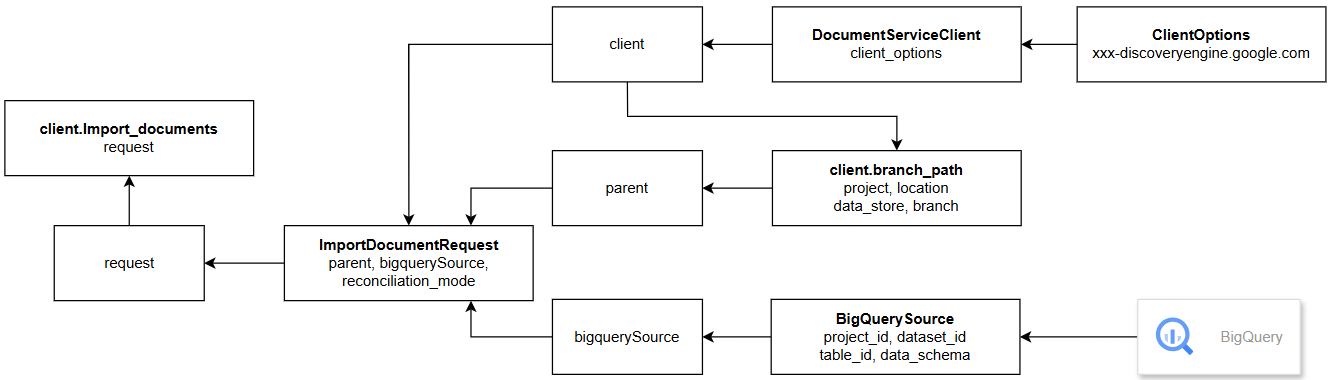

# 2. 코드 이해하기

## 2.1 기본 환경 설정

### 2.1.1 라이브러리 설치

In [ ]:
!pip install google-cloud-discoveryengine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.8 MB/s eta 0:00:00


In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 2.1.2 환경변수 설정

In [ ]:
PROJECT_ID = !gcloud config get-value project
PROJECT_ID=PROJECT_ID[0]
LOCATION="global"
DATASTORE_ID="bigquery_data_store"

## 2.2 bigquery

### 2.2.1 data upload

In [ ]:
!bq --location=US mk --dataset movies

Dataset 'younkicho-364103:movies' successfully created.


In [ ]:
!bq load --source_format=CSV --location=us --autodetect movies.movielens_movies_raw gs://dataeng-movielens/movies.csv

Waiting on bqjob_r7ce97760b75da36a_0000019462c40369_1 ... (4s) Current status: DONE   


### 2.2.2 결과 확인

In [ ]:
from google.cloud import bigquery

client = bigquery.Client()

In [ ]:
sql = """
SELECT
  *
FROM
  movies.movielens_movies_raw
LIMIT 10
"""

In [ ]:
# Run a Standard SQL query using the environment's default project
# df = client.query(sql).to_dataframe()

# Run a Standard SQL query with the project set explicitly
project_id = PROJECT_ID
df = client.query(sql, project=project_id).to_dataframe()

df.head()

,movieId,title,genres
0,777,Pharaoh's Army (1995),War
1,966,"Walk in the Sun, A (1945)",War
2,1450,Prisoner of the Mountains (Kavkazsky plennik) ...,War
3,2669,Pork Chop Hill (1959),War
4,2670,Run Silent Run Deep (1958),War


### 2.2.3 신규 table 생성

In [ ]:
# datastore에 저장할 경우 _id가 필요함.
!bq query \
    --destination_table movies.new_movielens_movies_raw \
    --replace \
    --use_legacy_sql=false \
'SELECT ROW_NUMBER() OVER (ORDER BY movieId) AS _id, * ' \
'FROM `younkicho-364103`.`movies`.`movielens_movies_raw` limit 100;'

Waiting on bqjob_r558a712c839adbaa_0000019462e2eb4c_1 ... (1s) Current status: DONE   
+-----+---------+---------------------------------------------------------------------------------+---------------------------------------------+
| _id | movieId |                                      title                                      |                   genres                    |
+-----+---------+---------------------------------------------------------------------------------+---------------------------------------------+
|  34 |      34 | Babe (1995)                                                                     | Children|Drama                              |
|  67 |      67 | Two Bits (1995)                                                                 | Drama                                       |
| 100 |     101 | Bottle Rocket (1996)                                                            | Adventure|Comedy|Crime|Romance              |
|  12 |      12 | Dracula: Dead and L

## 2.3 datastore

### 2.3.1 DataStore 만들기

In [ ]:
from google.api_core.client_options import ClientOptions
from google.cloud import discoveryengine

In [ ]:
def getClient(location, isDataStore: bool):
  client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )
  if isDataStore:
    return discoveryengine.DataStoreServiceClient(client_options=client_options)
  return discoveryengine.DocumentServiceClient(client_options=client_options)

In [ ]:
def create_datastore(project_id, location, datastore_id, client):
    parent = client.collection_path(
        project_id,
        location,
        collection="default_collection")

    # bigquery에서 data를 읽어 들일 경우 data-store는 NO_CONTENT여야 한다.
    data_store = discoveryengine.DataStore(
        display_name=datastore_id,
        industry_vertical=discoveryengine.IndustryVertical.GENERIC,
        solution_types=[discoveryengine.SolutionType.SOLUTION_TYPE_SEARCH],
        content_config=discoveryengine.DataStore.ContentConfig.NO_CONTENT
    )

    request = discoveryengine.CreateDataStoreRequest(
        parent=parent,
        data_store=data_store,
        data_store_id = DATASTORE_ID
    )

    return client.create_data_store(request=request)

In [ ]:
DATASTORE=True
client = getClient(LOCATION, DATASTORE)
operation = create_datastore(PROJECT_ID, LOCATION, DATASTORE_ID, client)
print(operation.result())

name: "projects/429718924597/locations/global/collections/default_collection/dataStores/bigquery_data_store"
display_name: "bigquery_data_store"
industry_vertical: GENERIC
solution_types: SOLUTION_TYPE_SEARCH
default_schema_id: "default_schema"
content_config: NO_CONTENT
serving_config_data_store {
}



### 2.3.2 bigquery에서 data 가져오기

In [ ]:
def importData(project_id, location, datastore_id, client, bigquery_dataset, bigquery_table):
  parent = client.branch_path(
    project= project_id,
    location=location,
    data_store=datastore_id,
    branch="default_branch"
  )

  bigquerySource = discoveryengine.BigQuerySource(
      project_id=project_id,
      dataset_id=bigquery_dataset,
      table_id=bigquery_table,
      data_schema="custom"
  )
  request = discoveryengine.ImportDocumentsRequest(
      parent=parent,
      bigquery_source=bigquerySource,
      reconciliation_mode = discoveryengine.ImportDocumentsRequest.ReconciliationMode.INCREMENTAL
  )

  return client.import_documents(request=request)

In [ ]:
DOCUMENTSERVICE=False
client = getClient(LOCATION, DOCUMENTSERVICE)
operation = importData(PROJECT_ID, LOCATION, DATASTORE_ID, client, "movies", "new_movielens_movies_raw")
operation.result()

error_config {
  gcs_prefix: "gs://429718924597_us_import_custom/errors9459071707760466023"
}

## 2.4 Gemini 확인

### 2.4.1 모델 생성

In [ ]:
import vertexai

In [ ]:
from vertexai.preview.generative_models import(
    GenerativeModel,
    GenerationConfig,
    Tool,
    grounding
)

In [ ]:
def getModel(project_id, init_location, grounding_location, datastore_id):
  vertexai.init(project=project_id, location=init_location)

  tool = Tool.from_retrieval(
      grounding.Retrieval(
          grounding.VertexAISearch(
              datastore=datastore_id,
              project=project_id,
              location=grounding_location
          )
      )
  )

  return GenerativeModel(
      "gemini-1.5-flash",
      generation_config=GenerationConfig(temperature=0.0),
      tools=[tool])

### 2.4.2 결과 확인

In [ ]:
init_location="us-east1"
model = getModel(PROJECT_ID, init_location, LOCATION, DATASTORE_ID)

In [ ]:
prompt="""
  장르가 코미디인 영화를 3개 추천해 줘
  아이디, 제목 순으로 출력해 줘
"""

response = model.generate_content(prompt)
print(response.text)

## 코미디 장르 영화 추천

1. **movieId: 18**, **title: Four Rooms (1995)**
2. **movieId: 58**, **title: Postman, The (Postino, Il) (1994)**
3. **movieId: 4**, **title: Waiting to Exhale (1995)** 

코미디 장르 영화 외에도 다양한 장르의 영화들이 많으니 취향에 맞는 영화를 찾아보세요! 



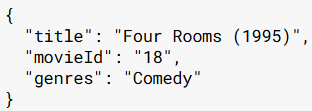

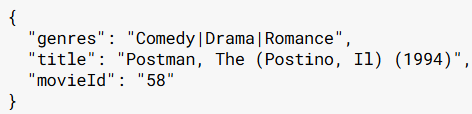

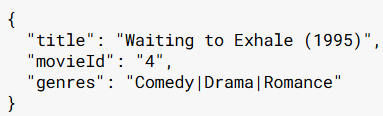

In [ ]:
prompt="""
  달달한 사랑 이야기로 3개만 추천해줘
  아이디, 제목 순으로 출력해 줘
"""

response = model.generate_content(prompt)
print(response.text)

## 달달한 사랑 이야기 추천

1. **movieId: 58**, **title: Postman, The (Postino, Il) (1994)**
2. **movieId: 74**, **title: Bed of Roses (1996)**
3. **movieId: 85**, **title: Angels and Insects (1995)** 



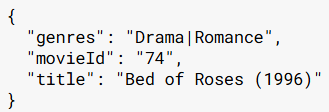

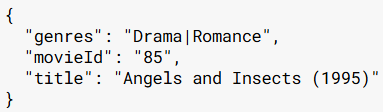

In [ ]:
prompt="""
  남자 영화로 추천해 줘
  아이디, 제목 순으로 출력해 줘
"""

response = model.generate_content(prompt)
print(response.text)

## 남자 영화 추천

**아이디, 제목 순으로 출력:**

* **69**, Friday (1995)
* **51**, Guardian Angel (1994)
* **66**, "Lawnmower Man 2: Beyond Cyberspace (1996)"
* **70**, From Dusk Till Dawn (1996) 

**추가 정보:**

* **Friday (1995)**: 코미디 장르로, 친구와 함께 겪는 일상적인 이야기를 유쾌하게 그려낸 영화입니다. 
* **Guardian Angel (1994)**: 액션, 드라마, 스릴러 장르로, 범죄와 맞서 싸우는 이야기를 다룹니다. 
* **"Lawnmower Man 2: Beyond Cyberspace (1996)"**: 액션, SF, 스릴러 장르로, 사이버 공간을 배경으로 펼쳐지는 이야기입니다. 
* **From Dusk Till Dawn (1996)**: 액션, 코미디, 호러, 스릴러 장르로, 긴박한 스토리와 흥미로운 설정이 특징입니다. 

**추천 기준:**

* 남성 관객들에게 인기 있는 장르인 액션, 코미디, 스릴러 장르를 중심으로 추천했습니다. 
* 다양한 취향을 고려하여 여러 장르의 영화를 포함했습니다. 

**추가 추천:**

* **Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)**: 코미디, 범죄 장르로, 유머와 풍자를 담은 영화입니다. 
* **American President, The (1995)**: 코미디, 드라마, 로맨스 장르로, 정치와 사랑을 다룬 영화입니다. 

**참고:**

* 위에 언급된 영화들은 모두 남성 관객들에게 인기 있는 영화입니다. 
* 영화의 취향은 개인마다 다르기 때문에, 위에 언급된 영화들이 모든 남성 관객들에게 적합하지 않을 수 있습니다. 



# 3. reference

* https://cloud.google.com/generative-ai-app-builder/docs/create-data-store-es?hl=ko#bq-import-once
* https://cloud.google.com/bigquery/docs/pandas-gbq-migration?hl=ko#standard-sql-query
* https://www.cloudskillsboost.google/course_templates/55/labs/507875?locale=tr
* https://cloud.google.com/php/docs/reference/cloud-discoveryengine/latest/V1.BigQuerySource
* https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.types.ImportDocumentsRequest


* https://helloworld.kurly.com/blog/vertex-ai-search-NR/